# Building a Custom Metric Function 

Developing machine learning models are often (and should be) based on iterative hypothesis testing.
Typically, you get some data and labels and train your first model.
Then, you realise that the model is performing worse than you had hoped.

Now, you starting hypothesizing about what might be wrong.
Perhaps you suspect that red objects make your model perform worse.
So you define a hypothesis like:

> Red objects have a significant impact on my model performance

Traditionally, the next thing you would do is to write a script for filtering, ordering, and visualising your validation data as a function of the object colors.
Something like this:

<details open="1" style="margin-bottom: 2rem; padding: .5rem 1rem; border: solid 1px black;">
<summary style="cursor: pointer; font-weight: 600; margin-bottom: 0.5rem">Code block that you can safely hide</summary>

```python
# DISCLAIMER: This is just to show how much code you need to write to test your hypothesis
#             It's not meant to work or to be copied in any way!

from functools import partial

color_ordering = [] 
acc = [] 

def compute_redness_of_objects(image, object):
    # Some code to determine colors
    # color_metric = ...
    return color_metric

for batch in validation_loader:
    for image, labels in batch:
        predictions = my_model(images)

        acc += ... # some hard to write code for match predictions with labels
        color_ordering += list(map(partial(get_colors_for_object, image=image), predictions))
        
color_ordering = np.array(color_ordering)
sorting = np.argsort(color_ordering)
color_ordering = color_ordering[ordering]
acc = np.array(color_ordering)[ordering]

# LOONG plotting code section for displaying samples, plots, and what not.
# ...
# ...
# ...
```
   
</details>

When you're finally done writing code and plotting things, hopefully you can reach a conclusion regarding your hypothesis.
When you reach this point, you will most likely have many more hypothesis that you want to test and eventually also more models to evaluate.
Do we need to mention how painful it will be to extend the code above with new use cases, plots, etc.?
What if you, for example, wanted to know the same thing, not only for your predictions but also for the labels? What about false negatives? .. and so on.

Encord Active solves this problem with a couple of points in focus:

1. **Reusability:** You define your metric function once and then you can reuse again and again.
2. **Isolation of functionality:** Since the metric function is defined in isolation from other metrics, you won't accidentally introduce errors in other functions, plots, etc.
3. **Iteration speed:** We've made it easy to implement your own metric function such that you can iterate faster.
4. **It's built from experience:** We have felt this pain many times and we have seen many of the common hypothesis that come up. We're building Encord Active to deel with all these common scenarios while being extensible enough to be tailored to your custom use case.

Other points that we want to highlight is that 

1. Encord Active ships with a bunch of [pre-defined metrics](https://docs.encord.com/active/docs/category/metrics) that will automatically be run on your data when you import it.
2. When you've [imported your model predictions](https://docs.encord.com/active/docs/workflows/import-predictions), Encord Active will _automatically_ identify those metrics that are more important for your model performance.

This tutorial will take you through how to write such metric functions and use them with Encord Active.

# Defining a `Metric` sub-class

Here, we'll give some detailed information on how a quality metric is defined.

> **🌟 Info**: If you don't like abstract talk, you can skip directly to [the example below](#concrete-example) to see how to implement a specific metric.

We have listed the entire stub below for defining a metric. Following right after is a breakdown of the different components.

In [7]:
from typing import List, Optional, Union

from encord_active.lib.common.iterator import Iterator
from encord_active.lib.metrics.metric import AnnotationType, DataType, MetricType, Metric
from encord_active.lib.metrics.writer import CSVMetricWriter

class ExampleMetric(Metric):
    # === SECTION 1 === #
    def __init__(self):
        super().__init__(
            title="[the-name-of-your-metric]",
            short_description="A short description of your metric.",
            long_description="A longer and more detailed description. " \
                       "I can use Markdown to _format_ the text.",
            metric_type=MetricType.GEOMETRIC,
            data_type=DataType.IMAGE,
            annotation_type=[AnnotationType.OBJECT.BOUNDING_BOX, AnnotationType.OBJECT.POLYGON],
        )

    def execute(self, iterator: Iterator, writer: CSVMetricWriter):
        valid_annotation_types = {annotation_type.value for annotation_type in self.metadata.annotation_type}

        for data_unit, img_pth in iterator.iterate(desc="Progress bar description"):
            # === SECTION 2 === #
            # Write a score for the image itself (data quality)
            writer.write(1337, description="Your description for the frame [can be omitted]")
            
            for obj in data_unit["labels"].get("objects", []):
                # === SECTION 3 === #
                # Label (object/classification) level score (label / model prediction quality)
                if not obj["shape"] in valid_annotation_types:
                    continue

                # Do your thing (inference)
                # ...
                # Then
                writer.write(42, labels=obj, description="Your description of the score [can be omitted]")

There are a couple of sections in the code above.  

`SECTION 1`: Is used for proper display of the values that the metric produces. The properties being set there are:

1. `title`: Is the title of your metric. It will be used in data frames and the app to identify the metric.
2. `metric_type`: We have distinguished metric types into three categories - `HEURISTIC`
    - `HEURISTIC`: operate on images or individual video frames and are heuristic in the sense that they mostly depend on the image content without labels.
    - `GEOMETRIC`: operate on the geometries of objects like bounding boxes, polygons, and polylines.
    - `SEMANTIC`: operate with the semantic information of images or individual video frames - for example, metrics based on NN embeddings would go here.
3. `data_type`: The type of data that the metric applies to.
    - `IMAGE`: Individual images witout any temporal dependencies.
    - `SEQUENCE`: Consecutive frames where order across frames matter.
4. `annotation_type`:
    - `NONE`: Doesn't need annotations (Data Quality)
    - `OBJECT`: A list of object types like polygon or bounding box that the metric works for.
    - `CLASSIFICATION`: A list of classification types like radio buttons and checkboxes that the metric works for.
    - `ALL`: All objects and classification types. Could, for example, be used for annotation time.
5. `short_description`: Used in the ui
6. `long_description`: Used in the ui


`SECTION 2`: Is used for metric functions that yield one score for each frame. Note how the `writer.write(...)` specifies no objects.

`SECTION 3`: Is used for metric functions that yield a score for each object / classification. For these metrics, `writer.write(...)` should contain a list of objects or classifications that should be associated with a giveen score.

> _Note:_ You should stick to either writing scores with or without the `writer.write(..., labels=obj)` argument. Mixing them up will confuse the app.

### Using the iterator
When you call `iterator.iterate(...)`, you will get an iterator over all the data in a given dataset (see how to execute the metric [below](#execute)). Each item in the iterator is a tuple of a `data_unit` dictionary and a `pathlib.Path` to where the image can be loaded from. 

The `data_unit` dictionary has the following structure (there may be more or less `"objects"` and `"labels"`):

<details open="1" style="margin-bottom: 2rem; padding: .5rem 1rem; border: solid 1px black;">
<summary style="cursor: pointer; font-weight: 600; margin-bottom: 0.5rem"><code>data_unit</code> example structure</summary>

```python
{
    "data_hash": "595d9721-913b-45c9-8645-c3ebf8a6ae0b",
    "data_title": "231822",
    "data_type": "image/jpeg",
    "data_sequence": 0,
    "labels": {
        "objects": [
            {  # Example polygon
                "name": "Bottle",
                "color": "#68BC00",
                "shape": "polygon",
                "value": "bottle",
                "polygon": {
                    "0": {"x": 0.9559, "y": 0.0038},
                    "1": {"x": 0.9356, "y": 0.1399},
                    "2": {"x": 0.9216, "y": 0.1982},
                    # ...
                },
                "createdAt": "Thu, 25 Aug 2022 15:45:31 GMT",
                "createdBy": "robot@cord.tech",
                "confidence": 1,
                "objectHash": "9728826c",
                "featureHash": "671c61d7",
                "lastEditedAt": "Thu, 25 Aug 2022 15:45:31 GMT",
                "lastEditedBy": "robot@encord.com",
                "manualAnnotation": False,
            },
            {  # Example bounding box
                "name": "Cyclist",
                "color": "#DBDF00",
                "shape": "bounding_box",
                "value": "Cyclist",
                "createdAt": "Wed, 23 Nov 2022 10:05:22 GMT",
                "createdBy": "robot@encord.com",
                "confidence": 1.0,
                "objectHash": "t2KUSWgj",
                "featureHash": "yJ+hgd0r",
                "lastEditedAt": "Wed, 23 Nov 2022 10:05:22 GMT",
                "lastEditedBy": "robot@encord.com",
                "manualAnnotation": True,
                "boundingBox": {
                    "h": 0.2810061626666667,
                    "w": 0.0897509331723027,
                    "x": 0.4464461135265701,
                    "y": 0.443804288,
                },
                "reviews": [],
            },
        ],
        "classifications": [
            {  # Example classification
                "name": "Classification Question",
                "value": "classification-question",
                "createdAt": "Fri, 11 Nov 2022 09:41:21 GMT",
                "createdBy": "robot@cord.tech",
                "confidence": 1,
                "featureHash": "MTYzMTkx",
                "classificationHash": "sHNoiYPw",
                "manualAnnotation": True,
                "reviews": [],
            }, 
            # ...
        ],
    },
    "data_link": "...",
    "width": 500,
    "height": 361,
}
```
</details>

> _💡 Hint:_ You can inpect the entire structure by looking in the file `/path/to/project/data/<label_hash>/label_row.json`.

> _Note:_ To find the actual answers to classification questions, you access `iterator.label_rows[iterator.label_hash]["classification_answers"][<classification_hash>]`.

> _Note:_ If you are computing metrics based on temporal aspects, the `iterator.frame` will tell you what frame of a sequence you are currently looking at and the `iterator.label_hash` will give you the unique id of the sequence.

<a id='execute'></a>
### Executing a metric

When you have implemented a metric function, you can run it using the following code snippet:

In [ ]:
from pathlib import Path
from encord_active.lib.metrics.execute import execute_metrics
from encord_active.lib.model_predictions.iterator import PredictionIterator

target = Path("/path/to/your/project") # TODO UPDATE

execute_metrics([ExampleMetric()], data_dir=target, use_cache_only=True)  # for labels
execute_metrics([ExampleMetric()], data_dir=target, iterator_cls=PredictionIterator, use_cache_only=True)  # for predictions (only makes sense to do if your metric applies to labels)

# Wrap this entire code block in a 
# `if __name__ == "__main__":`
# and put it in the bottom of your metric file if you want to be able to run
# python your_metric.py

The `target` variable points to the directory that containts the Encord Active project that you want to run the metric on.
This directory should, for example, contain a `project-meta.yaml`.

> Info: The `use_cache_only` argument tells Encord Active to not try and download more data via the Encord SDK.

Having covered the overall structure, let's dive into a concrete example.

<a id='concrete-example'></a>
# Concrete Walk through Example

> 💡 Hint: We refer to line numbers. In most notebooks, you can enable line numbers in the "View" options.

In this example, we'll continue the idea of testing the model performance as a function of the "redness" of individual objects. 
Specifically, we will use the annotations/predictions to extract the image patchs that contain an object and compute the mean Hue value of that patch.

To get started, let's have a look at the [HSV color space](https://en.wikipedia.org/wiki/HSL_and_HSV), which is great for color filtering.
The following code indicates how different Hue (the H from HSV) values correspond to different colors.

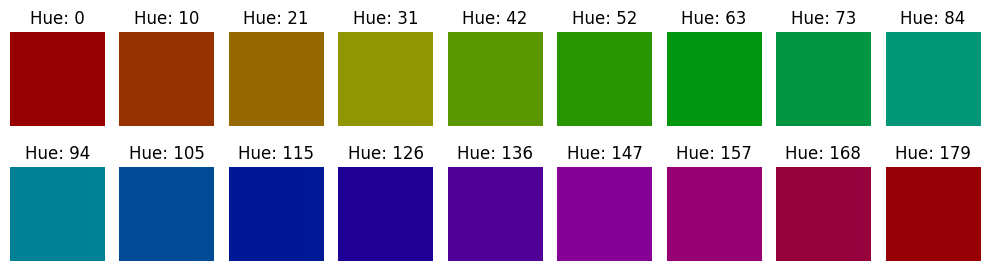

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def get_img(H: int):
    """
    Make image with specific Hue color and convert it to RGB for plotting.
    """
    img =  np.ones((20, 20, 3), dtype=np.uint8)
    img[..., 0] = H
    img[..., 1] = 255
    img[..., 2] = 150 
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

# Hue ranges from 0 to 180 and "wraps" around.
hues = np.linspace(0, 179, 18, dtype=np.uint8)
imgs = [get_img(i) for i in hues]

fig, ax = plt.subplots(2, 9, figsize=(10, 3))
ax = ax.reshape(-1)

# Plot the colors
for  img, a, h in zip(imgs, ax, hues):
    a.set_title(f"Hue: {h}")
    a.axis('off')
    a.imshow(img)

fig.tight_layout()
plt.show()

Note how the first and the last images are very red but have very different hue values. 
This is because of the "circular" / "wrap-around" nature of the color space. 
Let's account for that by computing a value, which makes red colors close to zero and others closer to one.

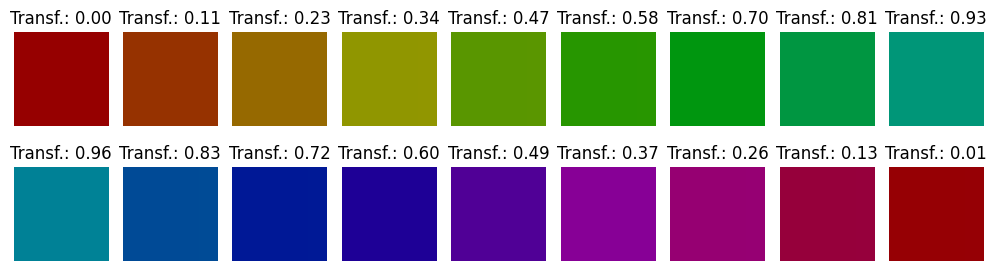

In [2]:
def transform_hue(H: int, offset=0):
    return (90 - np.abs(H - 90)) / 90

# Plotting
fig, ax = plt.subplots(2, 9, figsize=(10, 3))
ax = ax.reshape(-1)

for img, a, h in zip(imgs, ax, hues):
    t = transform_hue(h)
    a.set_title(f"Transf.: {t:.2f}")
    a.imshow(img)
    a.axis('off')
fig.tight_layout()

Alright, this looks better.
The transformed value is a better candidate for our metric function.

Next, let's use this to crop out the relevant parts of polygon annotations and compute their mean (transformed) hue values.

We define a `Metric` subclass and compute the transformed hue value for each object to see how red it is.

In [ ]:
import numpy as np
from encord_active.lib.common import utils
from encord_active.lib.common.iterator import Iterator
from encord_active.lib.metrics.metric import AnnotationType, DataType, Metric, MetricType
from encord_active.lib.metrics.writer import CSVMetricWriter
from loguru import logger


class ObjectRedness(Metric):
    def __init__(self):
        super().__init__(
            title="Polygon Average Hue",
            short_description="Compute the average Hue value of the pixels contained within each polygon.",
            long_description=r"""Crops out the pixels associated to each object and computes the (transformed)
Hue value of each object.

The transform "breaks" the wrap-around of the Hue color space, so Hue values in range [0, 180] becomes [0, 1] as follows:

```
H:    [0,  45, 90, 135, 179]
t(H): [0, 0.5,  1, 0.5, 0+e]
```
""",
            metric_type=MetricType.SEMANTIC ,
            data_type=DataType.IMAGE,
            annotation_type=[AnnotationType.OBJECT.POLYGON],
        )

    def execute(self, iterator: Iterator, writer: CSVMetricWriter):
        valid_annotation_types = {annotation_type.value for annotation_type in self.metadata.annotation_type}

        # Separate objects' instances (same objectHash [aka track id] means same object instance)
        for data_unit, img_pth in iterator.iterate(desc="Custom progress description"):
            # Read the image and convert it to the HSV color space
            full_image = cv2.imread(img_pth.as_posix())
            full_hsv_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2HSV)[...,0]  # Take only the hue channel
            img_h, img_w = full_hsv_image.shape[:2]
            
            for obj in data_unit["labels"].get("objects", []):
                if not obj["shape"] in valid_annotation_types:
                    continue  # Only use polygons
                
                # The `get_geometry_from_encord_object` function will get us a numpy array of xy coordinates.
                poly: Optional[np.ndarray] = utils.get_geometry_from_encord_object(obj, w=img_w, h=img_h)  # [n, d]
                if poly is None:
                    continue
                
                # Check that the polygon takes up at least one pixel
                ymi, xmi = poly.min(0)
                yma, xma = poly.max(0)
                
                if ymi == yma or xmi == xma:
                    continue  # Empty polygon
                                
                # Draw mask from polygon
                mask = np.zeros((img_h, img_w), dtype=np.uint8)
                mask = cv2.fillPoly(mask, [poly], 1)
                
                polygon_pixels = full_hsv_image[mask==1]  # Take only pixels within polygon
                transformed_mean_hue = transform_hue(polygon_pixels.mean())
                writer.write(transformed_mean_hue.item(), labels=obj)

Okay, so we have defined our metric which extracts the pixels of each polygon and computes the average (transformed) hue value of those pixels.
The next step will then be to apply the metric to our data.

In the next code cell, we'll download one of the sandbox datasets, but you can also point the metric to your own dataset by setting the `target` path below to point to the root of your project directory.

In [ ]:
# Download the "quickstart" sandbox dataset.
!encord-active download --project-name quickstart

You should now be able to see the quickstart directory in the "File Browser". 
Let's apply our metric to that project.

In [ ]:
from pathlib import Path
from encord_active.lib.metrics.execute import execute_metrics

target = Path("quickstart")

# Apply metric to labels
execute_metrics([ObjectRedness()], data_dir=target, use_cache_only=True)

# For predictions (only makes sense to do if your metric applies to labels)
from encord_active.lib.model_predictions.iterator import PredictionIterator
execute_metrics([ObjectRedness()], data_dir=target, iterator_cls=PredictionIterator, use_cache_only=True)

# Wrap this entire code block in a 
# `if __name__ == "__main__":`
# and put it in the bottom of your metric file if you want to be able to run
# python your_metric.py

To see the results, you can run the app with the project as the target:

In [ ]:
!encord-active visualise -t "quickstart"

For the quickstart dataset, the "Polygon Average Hue" metric that we just defined seems to have little or no influence on the model performance - based on the "Metric Importance" chart on the "Model Quality -> Metrics" page.
However, if you filter by the person class in the settings panel in the top, you will see that the redness of objects do seem to have an effect on the model performance.

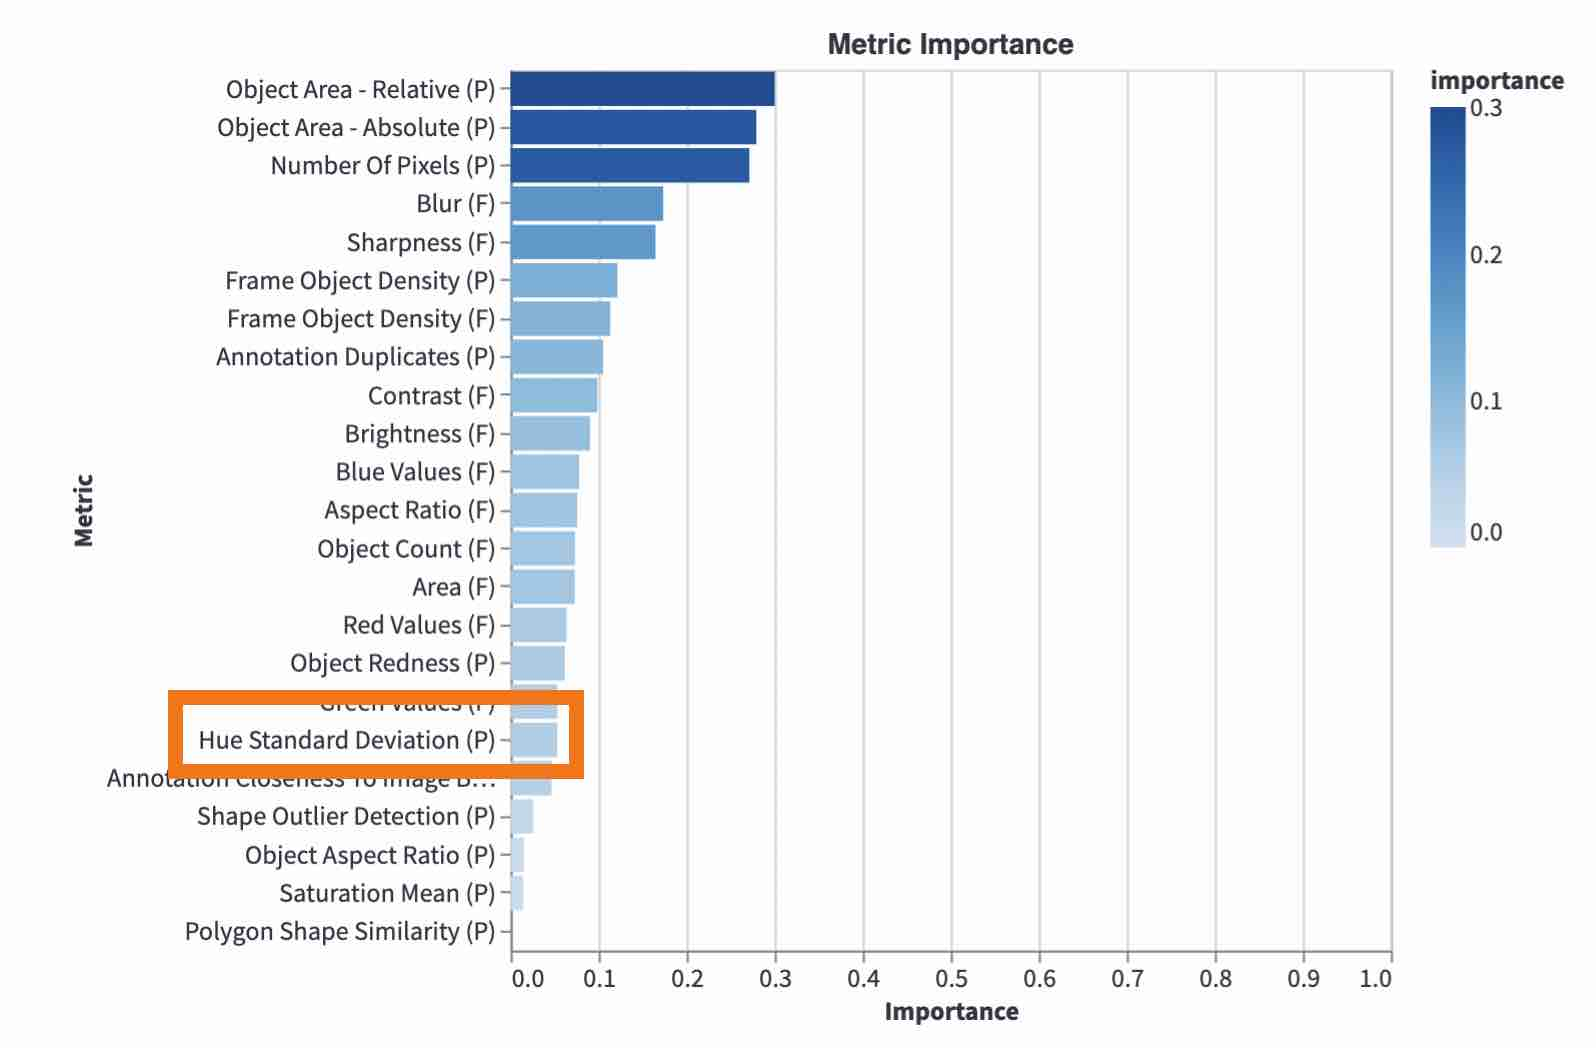

## What's Next?

The next steps from here could be many.
We have seen that the redness of objects is generally not extremely important for the model performance - which is a good thing - one less thing to worry about.

From here, one could go on to define a new custom metric function to test the next hypothesis.
Some of the things that would be simple to test now that we have our first custom metric in place is, e.g., the standard deviation of the colors within an object, the saturaion, other colors, etc. These metrics would only require changing line 57 in the metric definition above.

Of course, we should keep all the metrics that we define to make sure that redness of values doesn't turn into a problem at a later stage in the model development.